# #1 Bayesian Linear Regression

Bayesian Linear Regression with toy data in 1D.


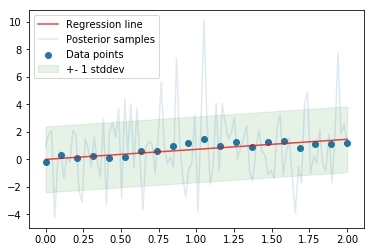

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


# Generate data
M = 20

X = np.linspace(0, 2, num=M)
# X = np.array([5, 14, 19], dtype=np.float)
t_real = np.sin(X)
t = t_real + np.random.randn(M) * 0.25

plt.scatter(X, t, label='Data points')

# Generative process: p(t|W,X,beta) = N(t|XW+b,beta)
beta = 1

# Prior: N(w|0,1/alpha*I)
alpha = 1

# Posterior: N(w|m,s):
s = 1/(alpha + beta * X.T @ X)
m = beta * s * X.T @ t

# Infer p(t|t,alpha,beta) the predictive distribution
X_pred = np.linspace(0, 2, num=100)

m_pred = m * X_pred
s_pred = 1/beta + X_pred.T @ X_pred * s
std_pred = np.sqrt(s_pred)

plt.plot(X_pred, m_pred, color='red', alpha=0.75, label='Regression line')
plt.fill_between(
    X_pred, m_pred-std_pred, m_pred+std_pred,
    interpolate=True, color='green', alpha=0.1, label='+- 1 stddev'
)

# Sample from predictive dist.
ys = np.random.normal(m_pred, std_pred)

plt.plot(X_pred, ys, alpha=0.15, label='Posterior samples')
plt.legend(loc='best')
plt.show()

# #2 Bayesian Dark Knowledge

Bayesian Dark Knowledge
Korattikara, et. al., 2015

In [2]:

import numpy as np
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

N = mnist.train.images.shape[0]  # training set size
M = 100  # minibatch size
T = 10000  # num of iteration

Theta = np.vstack([np.zeros([1, y_dim]), np.random.randn(X_dim, y_dim) * 0.001])
W = np.vstack([np.zeros([1, y_dim]), np.random.randn(X_dim, y_dim) * 0.001])


def softmax(x):
    m = np.max(x)
    return np.exp(x - m) / np.sum(np.exp(x - m))


# SGLD Teacher-Student distillation
# ---------------------------------

eta = 0.1  # teacher learning rate
rho = 0.1  # student learning rate
lam = 1  # teacher prior
gam = 1e-3  # student prior

burnin = 1000
thinning = 10

for t in range(1, T+1):
    # Train teacher
    # -------------
    X_mb, y_mb = mnist.train.next_batch(M)
    X_train = np.hstack([X_mb, np.ones([M, 1])])  # add bias dim

    eta_t = eta/t

    p = softmax(X_train @ Theta)
    grad_p = p - y_mb

    grad_loglik = X_train.T @ grad_p  # 784x16 . 16x10
    grad_logprior = lam * Theta
    grad_logpost = grad_logprior + N/M * grad_loglik

    z = np.random.normal(0, np.sqrt(eta_t))
    delta = eta_t/2 * grad_logpost + z
    Theta += delta

    if t > burnin and t % thinning == 0:
        # Train student
        # -------------
        X_s_mb = X_mb + np.random.normal(0, 1e-3)  # perturb
        X_s_train = np.hstack([X_s_mb, np.ones([M, 1])])  # add bias dim
        rho_t = rho/t

        s = softmax(X_s_train @ W)
        p = softmax(X_s_train @ Theta)
        grad_s = s - p

        grad_loglik = X_s_train.T @ grad_s  # 784x16 . 16x10
        grad_logprior = gam * W
        grad_logpost = grad_logprior + 1/M*grad_loglik

        delta = rho_t * grad_logpost
        W -= delta

    # Diagnostics
    # -----------
    if t % 1000 == 0:
        s = softmax(X_train @ W)
        loss = -gam/2 * np.sum(W**2) - np.sum(y_mb * np.log(s + 1e-8))
        print('Iter: {}; S_loss: {:.4f}'.format(t, loss))


# Test
# ----

X_test, y_test = mnist.test.images, mnist.test.labels
X_test = np.hstack([X_test, np.ones([X_test.shape[0], 1])])  # add bias dim

y = softmax(X_test @ W)
acc = np.mean(y.argmax(axis=1) == y_test.argmax(axis=1))

print('Test accuracy: {:.4f}'.format(acc))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Iter: 1000; S_loss: 690.7835
Iter: 2000; S_loss: 690.7092
Iter: 3000; S_loss: 690.7138
Iter: 4000; S_loss: 690.7006
Iter: 5000; S_loss: 690.7684
Iter: 6000; S_loss: 690.7776
Iter: 7000; S_loss: 690.7752
Iter: 8000; S_loss: 690.7309
Iter: 9000; S_loss: 690.8474
Iter: 10000; S_loss: 690.6991
Test accuracy: 0.0464


# #3 GMM Gibbs 

Posterior sampling for Gaussian Mixture Model using Gibbs sampler


In [3]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


K = 2

# Generate data
X1 = np.random.multivariate_normal([5, 5], np.diag([0.5, 0.5]), size=20)
X2 = np.random.multivariate_normal([8, 8], np.diag([0.5, 0.5]), size=20)
X = np.vstack([X1, X2])

N = X.shape[0]

# GMM params
mus = np.array([[1, 1], [15, 15]], dtype='float')
sigmas = np.array([np.diag([1, 1]), np.diag([1, 1])], dtype='float')
lambdas = np.array([np.linalg.inv(sigmas[0]), np.linalg.inv(sigmas[1])])
pis = np.array([0.5, 0.5])  # Mixing probs.
zs = np.zeros([N])  # Assignments

# Priors
alpha = np.array([1, 1])
pis = np.random.dirichlet(alpha)
mus0 = np.array([[1, 1], [1, 1]], dtype='float')
sigmas0 = np.array([np.diag([1, 1]), np.diag([1, 1])], dtype='float')
lambdas0 = np.array([np.linalg.inv(sigmas0[0]), np.linalg.inv(sigmas0[1])])

# Gibbs sampler
for it in range(50):
    # Sample from full conditional of assignment
    # z ~ p(z) \propto pi*N(y|pi)
    probs = np.zeros([N, K])

    for k in range(K):
        p = pis[k] * st.multivariate_normal.pdf(X, mean=mus[k], cov=sigmas[k])
        probs[:, k] = p

    # Normalize
    probs /= np.sum(probs, axis=1)[:, np.newaxis]

    # For each data point, draw the cluster assignment
    for i in range(N):
        z = np.random.multinomial(n=1, pvals=probs[i]).argmax()
        zs[i] = z

    # Sample from full conditional of cluster parameter
    # Assume fixed covariance => posterior is Normal
    # mu ~ N(mu, sigma)
    Ns = np.zeros(K, dtype='int')

    for k in range(K):
        # Gather all data points assigned to cluster k
        Xk = X[zs == k]
        Ns[k] = Xk.shape[0]

        # Covariance of posterior
        lambda_post = lambdas0[k] + Ns[k]*lambdas[k]
        cov_post = np.linalg.inv(lambda_post)

        # Mean of posterior
        left = cov_post
        right = lambdas0[k] @ mus0[k] + Ns[k]*lambdas[k] @ np.mean(Xk, axis=0)
        mus_post = left @ right

        # Draw new mean sample from posterior
        mus[k] = st.multivariate_normal.rvs(mus_post, cov_post)

    # Sample from full conditional of the mixing weight
    # pi ~ Dir(alpha + n)
    pis = np.random.dirichlet(alpha + Ns)

# Expected output:
# ----------------
# 20 data in cluster-0, mean: [ 5  5 ]
# 20 data in cluster-1, mean: [ 8  8 ]
for k in range(K):
    print('{} data in cluster-{}, mean: {}'.format(Ns[k], k, mus[k]))

20 data in cluster-0, mean: [ 4.51710905  5.00999685]
20 data in cluster-1, mean: [ 7.77123298  7.78397887]


# #4 GMM Variation

Posterior sampling for 2D-Gaussian Mixture Model using Mean-Field VI

In [4]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


K = 2

# Generate data
X1 = np.random.multivariate_normal([-5, -5], np.diag([2, 0.5]), size=20)
X2 = np.random.multivariate_normal([18, 18], np.diag([0.7, 1]), size=20)
X = np.vstack([X1, X2])

N = X.shape[0]

# GMM params initialization
mu = np.array([[1, 1], [2, 2]], dtype=float)
var = np.array([1, 1], dtype=float)
phi = np.zeros([N, K]) + 1/K
c = np.random.randint(K, size=N)  # Assignments

# Priors
var0 = 1

for it in range(5):
    # Update variational param phi, the assignment probs
    for k in range(K):
        phi[:, k] = np.exp(X @ mu[k] - (2*var[k] + mu[k].T @ mu[k])/2)

    # Normalize
    phi /= np.sum(phi, axis=1)[:, np.newaxis]
    # Update assignments
    c = np.argmax(phi, axis=1)

    # Update variational param mu and var, the params of Gaussian component
    for k in range(K):
        sum_phi = np.sum(phi[:, k])
        mu[k] = phi[:, k] @ X / (1/var0 + sum_phi)
        var[k] = 1 / (1/var0 + sum_phi)


# Expected output:
# ----------------
# 20 data in cluster-0, mean: [ -5  -5 ]
# 20 data in cluster-1, mean: [ 18  18 ]
for k in range(K):
    n = np.sum(c == k)
    print('{} data in cluster-{}, mean: {}'.format(n, k, mu[k]))

20 data in cluster-0, mean: [-4.45036297 -4.87464662]
20 data in cluster-1, mean: [ 17.07966899  17.1744302 ]


# #5 GMM Variational 1-D 

Posterior sampling for Gaussian Mixture Model using Gibbs sampler


In [6]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


K = 2

# Generate data
X1 = np.random.normal(-5, 0.5, size=20)
X2 = np.random.normal(3, 0.5, size=20)
X = np.concatenate([X1, X2])

N = X.shape[0]

# GMM params initialization
mu = np.array([50, -20], dtype=float)
var = np.array([1, 1], dtype=float)
phi = np.zeros([N, K]) + 1/K
c = np.zeros([N, K])  # Assignments

# Priors
mu0 = 0
var0 = 1

for it in range(5):
    # Update variational param phi, the assignment probs
    for k in range(K):
        phi[:, k] = np.exp(mu[k]*X - (mu[k]**2 + var[k])/2)

    # Normalize
    phi /= np.sum(phi, axis=1)[:, np.newaxis]
    # Update assignments
    c[np.argmax(phi, axis=1)] = 1

    # Update variational param mu and var, the params of Gaussian component
    for k in range(K):
        sum_phi = np.sum(phi[:, k])
        mu[k] = phi[:, k] @ X / (1/var0 + sum_phi)
        var[k] = 1 / (1/var0 + sum_phi)


# Expected output:
# ----------------
# 20 data in cluster-0, mean: -5
# 20 data in cluster-1, mean: 3
for k in range(K):
    n = np.sum(c == k)
    print('{} data in cluster-{}, mean: {}'.format(n, k, mu[k]))

76 data in cluster-0, mean: 2.8807925918438864
4 data in cluster-1, mean: -4.795346463816408


# #6 LDA with Collapsed Gibb's Sampler 

LDA with Collapsed Gibbs Sampler

Reference: Kevin Murphy's book Ch. 27


In [7]:
import numpy as np


# Words
W = np.array([0, 1, 2, 3, 4])

# X := document words
X = np.array([
    [0, 0, 1, 2, 2],
    [0, 0, 1, 1, 1],
    [0, 1, 2, 2, 2],
    [4, 4, 4, 4, 4],
    [3, 3, 4, 4, 4],
    [3, 4, 4, 4, 4]
])

N_D = X.shape[0]  # num of docs
N_W = W.shape[0]  # num of words
N_K = 2  # num of topics

# Dirichlet priors
alpha = 1
gamma = 1


# --------------
# Initialization
# --------------

# Z := word topic assignment
Z = np.zeros(shape=[N_D, N_W], dtype=int)

# Some counts for sufficient statistics
c_ik = np.zeros(shape=[N_D, N_K], dtype=int)
c_vk = np.zeros(shape=[N_W, N_K], dtype=int)
c_k = np.zeros(shape=N_K, dtype=int)

for i in range(N_D):
    for v in range(N_W):
        # Randomly assign word's topic
        k = np.random.randint(N_K)
        Z[i, v] = k

        # Record counts
        c_ik[i, k] += 1
        c_vk[v, k] += 1
        c_k[k] += 1


L = np.array([x.size for x in X])


# --------------
# Gibbs sampling
# --------------

for it in range(1000):
    # Sample from full conditional of Z
    # ---------------------------------
    for i in range(N_D):
        for v in range(N_W):
            # Sufficient statistics for the full conditional
            k = Z[i, v]
            c_ik[i, k] -= 1
            c_vk[v, k] -= 1
            c_k[k] -= 1

            # Calculate full conditional p(z_iv | .)
            left = (c_vk[v, :] + gamma) / (c_k + N_W*gamma)
            right = (c_ik[i, :] + alpha) / (L[i] + N_K*alpha)

            p_z_iv = left * right
            p_z_iv /= np.sum(p_z_iv)

            # Resample word topic assignment
            k = np.random.multinomial(1, p_z_iv).argmax()

            # Update counts
            Z[i, v] = k
            c_ik[i, k] += 1
            c_vk[v, k] += 1
            c_k[k] += 1


print('Documents:')
print('----------')
print(X)

print()

print('Document topic distribution:')
print('----------------------------')
print((c_ik + alpha) / np.sum(c_ik + alpha, axis=1)[:, np.newaxis])

print()

print('Topic word distribution:')
print('----------------------------')
x = (c_vk + gamma).T
print(x / np.sum(x, axis=1)[:, np.newaxis])

Documents:
----------
[[0 0 1 2 2]
 [0 0 1 1 1]
 [0 1 2 2 2]
 [4 4 4 4 4]
 [3 3 4 4 4]
 [3 4 4 4 4]]

Document topic distribution:
----------------------------
[[ 0.14285714  0.85714286]
 [ 0.57142857  0.42857143]
 [ 0.57142857  0.42857143]
 [ 0.71428571  0.28571429]
 [ 0.42857143  0.57142857]
 [ 0.28571429  0.71428571]]

Topic word distribution:
----------------------------
[[ 0.33333333  0.22222222  0.11111111  0.05555556  0.27777778]
 [ 0.09090909  0.18181818  0.27272727  0.31818182  0.13636364]]


# #7 LDA with Gibb's Sampler 

LDA with Gibbs Sampler
Reference: Kevin Murphy's book Ch. 27


In [8]:
import numpy as np


# Words
W = np.array([0, 1, 2, 3, 4])

# D := document words
X = np.array([
    [0, 0, 1, 2, 2],
    [0, 0, 1, 1, 1],
    [0, 1, 2, 2, 2],
    [4, 4, 4, 4, 4],
    [3, 3, 4, 4, 4],
    [3, 4, 4, 4, 4]
])

N_D = X.shape[0]  # num of docs
N_W = W.shape[0]  # num of words
N_K = 2  # num of topics

# Dirichlet priors
alpha = 1
gamma = 1


# --------------
# Initialization
# --------------

# Z := word topic assignment
Z = np.zeros(shape=[N_D, N_W])
for i in range(N_D):
    for l in range(N_W):
        Z[i, l] = np.random.randint(N_K)  # randomly assign word's topic

# Pi := document topic distribution
Pi = np.zeros([N_D, N_K])
for i in range(N_D):
    Pi[i] = np.random.dirichlet(alpha*np.ones(N_K))

# B := word topic distribution
B = np.zeros([N_K, N_W])
for k in range(N_K):
    B[k] = np.random.dirichlet(gamma*np.ones(N_W))


# --------------
# Gibbs sampling
# --------------

for it in range(1000):
    # Sample from full conditional of Z
    # ---------------------------------
    for i in range(N_D):
        for l in range(N_W):
            # Calculate params for Z
            p_bar_il = np.exp(np.log(Pi[i]) + np.log(B[:, X[i, l]]))
            p_il = p_bar_il / np.sum(p_bar_il)

            # Resample word topic assignment Z
            z_il = np.random.multinomial(1, p_il)
            Z[i, l] = np.argmax(z_il)

    # Sample from full conditional of Pi
    # ----------------------------------
    for i in range(N_D):
        m = np.zeros(N_K)

        # Gather sufficient statistics
        for k in range(N_K):
            m[k] = np.sum(Z[i] == k)

        # Resample doc topic dist.
        Pi[i, :] = np.random.dirichlet(alpha + m)

    # Sample from full conditional of B
    # ---------------------------------
    for k in range(N_K):
        n = np.zeros(N_W)

        # Gather sufficient statistics
        for v in range(N_W):
            for i in range(N_D):
                for l in range(N_W):
                    n[v] += (X[i, l] == v) and (Z[i, l] == k)

        # Resample word topic dist.
        B[k, :] = np.random.dirichlet(gamma + n)


print('Documents:')
print('----------')
print(X)

print()

print('Document topic distribution:')
print('----------------------------')
print(Pi)

print()

print('Topic\'s word distribution:')
print('-------------------------')
print(B)

print()

print('Word topic assignment:')
print('-------------------------')
print(Z)

Documents:
----------
[[0 0 1 2 2]
 [0 0 1 1 1]
 [0 1 2 2 2]
 [4 4 4 4 4]
 [3 3 4 4 4]
 [3 4 4 4 4]]

Document topic distribution:
----------------------------
[[ 0.53798222  0.46201778]
 [ 0.86426942  0.13573058]
 [ 0.78028235  0.21971765]
 [ 0.02622966  0.97377034]
 [ 0.0618754   0.9381246 ]
 [ 0.22269837  0.77730163]]

Topic's word distribution:
-------------------------
[[ 0.21615902  0.23579512  0.45697282  0.08111374  0.0099593 ]
 [ 0.02411378  0.02508557  0.05772617  0.19206773  0.70100675]]

Word topic assignment:
-------------------------
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.]]
